# Wonky Tops
### Marina Ten, Floris Strijbos, Tom Wade

In [10]:
import pandas as pd
import numpy as np
import ipyvolume as ipv

In [11]:
%pwd

'C:\\Users\\Thomas.Wade\\OneDrive - Shell\\python\\hackathon\\git\\wonkeycontact'

In [107]:
#Read Input tops data from excel file
from pandas import read_excel
my_sheet_name = 'Sheet1' 
df = read_excel('11_2.xlsx', sheet_name = my_sheet_name)

In [13]:
#df.loc[:,['UID','Well','Top','Interpreter','Depth_MD','Easting','Northing','Depth_tvdss']]

In [14]:
#df.loc[df.Top.isin(['AS11.2','T AS11.2']), ['Easting','Northing','Depth_tvdss']]

In [108]:
#Extract XYZ from dataframe
xyz=df.loc[df.Top.isin(['AS11.2','T AS11.2']), ['Easting','Northing','Depth_tvdss']].values

In [16]:
#Exctract XYZ values for processing
x=xyz[:,0]
y=xyz[:,1]
z=xyz[:,2]

In [17]:
#Get extents of input data
xmin=x.min() ; ymin=y.min() ; xmax=x.max() ; ymax=y.max() ; zmin=z.min() ; zmax=z.max()

### Initial processing to mathematically remove obvious outliers

In [18]:
def outliers_iqr(z):
    """
    The interquartile range (IQR), also called the midspread or middle 50%, 
    or technically H-spread, is a measure of statistical dispersion, being equal to the difference 
    between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.
    In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles 
    can be clearly seen on a box plot on the data.
    It is a measure of the dispersion similar to standard deviation or variance, but is much more robust 
    against outliers.
    """
    quartile_1, quartile_3 = np.percentile(z, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((z > upper_bound) | (z < lower_bound))
iqr_test = outliers_iqr(z)[0].tolist()
x_smooth = np.delete(x,iqr_test)
y_smooth = np.delete(y,iqr_test)
z_smooth = np.delete(z,iqr_test)
ipv.figure()
s = ipv.scatter(x_smooth, y_smooth, z_smooth, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Iterative interactive editing, round1

In [19]:
#Select points in plot above interactively, using CTRL-R
s_sel=s.selected
k=s_sel[0].tolist()

In [20]:
#Pick up points edited in first 'outlier edit' funtion
x= x_smooth
y = y_smooth
z = z_smooth

In [21]:
#Delete the points
xdel=np.delete(x,k)
ydel=np.delete(y,k)
zdel=np.delete(z,k)

In [22]:
#Redraw the plot with the update pointset
ipv.figure()
sdel = ipv.scatter(xdel, ydel, zdel, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Second edit iteration

In [23]:
#Select points in plot above, using CTRTL-R. Then procede to select and delete:
k2=sdel.selected[0].tolist()

In [24]:
#Delete the selected points
xdel2=np.delete(xdel,k2)
ydel2=np.delete(ydel,k2)
zdel2=np.delete(zdel,k2)

In [25]:
#Redraw the plot. Presume no further edits after this
ipv.figure()
sdel2 = ipv.scatter(xdel2, ydel2, zdel2, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Grid up  edited data

In [26]:
#Reassign edited data to X,Y,Z variable
x, y, z = xdel2, ydel2, zdel2

### Grid Tops via minimum curvature
##### Note this was our first gridding approach. However, a depopulated appoach is going to be preferred...

In [27]:
#Create a grid outline from tops data extent. Start printing extent
print("Xmin = {} , XMax = {}\nYmin = {}, Ymax= {}\nZmin = {}, Zmax = {}".format(xmin, xmax, ymin, ymax, zmin, zmax))

Xmin = 595608.87 , XMax = 628209.11
Ymin = 6639937.51, Ymax= 6699306.54
Zmin = -3000.22, Zmax = -2108.3


In [28]:
#Create sensible grid outline of integers. Currently hardcoded...
extent = [596000, 628500, 6640000, 6700000] #Sensible numbers from observed Xmin and Ymin. Defines Grid
grid_int = 100 #Hard coded grid spacing
#Create arrays of the x and y axis
x_points = int((extent[1] - extent[0]) / grid_int) #Number of samples in the X-Direction
y_points = int((extent[3] - extent[2]) / grid_int #Number of samples in the Y-Direction

In [29]:
#Create the grid. interval expressed by complex numbers
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:complex(x_points), extent[2]:extent[3]:complex(y_points)]

In [30]:
#Create numpy arrays of point co-ordinates and then values from input data
points = np.array(list(zip(x, y)))
values = z

In [31]:
#Perform interpolation of data in to the specified grid using scipy
from scipy.interpolate import griddata
gridded = griddata(points, values, (grid_x, grid_y), method='cubic')

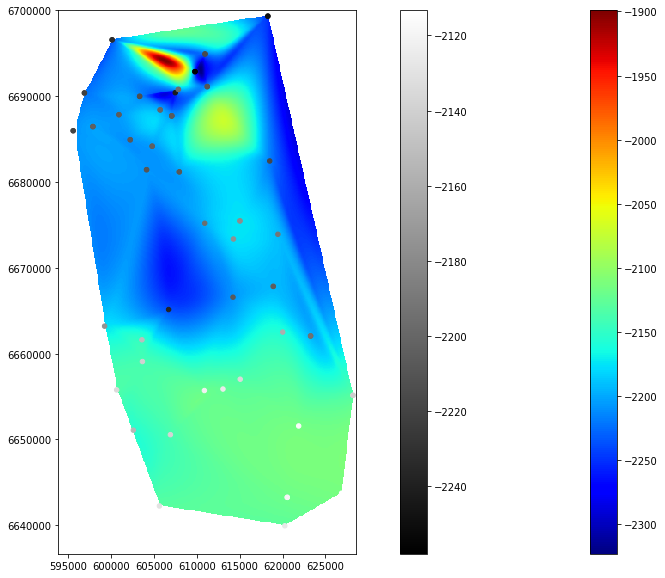

In [91]:
#Initial plot, Pre-Residuals. Can probs delete later
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.imshow(gridded.T, origin='lower', extent=extent, cmap='jet')
plt.colorbar()
plt.scatter(x, y, s=20, c=z)

plt.gray()
plt.colorbar()

### Residuals Extraction

In [49]:
import bruges #Utilise the coordinate transformation functions

In [54]:
# UTM coords of 3 unique inline, crossline locations. Taken from grid extents (realworld)
corners_xy = np.array([[596000, 6640000],
                       [596000, 6700000],
                       [628500, 6640000]])

# The inline, crossline locations you just provided. Also Grid extent, but as indices given by grid.shape
corners_ix = np.array([[0,  0],
                       [0, 600],
                       [325, 0]])

In [55]:
transform = bruges.transform.CoordTransform(corners_ix, corners_xy)

In [56]:
#Pissing about to  create lists of well-top coordinates (as currently in np.array). Then transform
xlist = x.tolist()
ylist = y.tolist()
merge = list(zip(xlist, ylist))
coordinates = []
for i in merge:
    coordinates.append(transform.reverse([i[0], i[1]]))

In [58]:
#Then convert the indicies back to numpy arrays
xcors = np.array([item[0] for item in coordinates])
ycors = np.array([item[1] for item in coordinates])

In [61]:
#Extract the value of the grid at the well top locations
z_gridded = gridded[(xcors, ycors)]

In [84]:
#Calculate the residuals by subtracting gridded value from input top value
residuals = z - z_gridded

In [85]:
#Put the residuals in to a dataframe for visualisation
d = {'x': x, 'y': y, 'z':z, 'z_gridded': z_gridded, 'residual': residuals}
res_df = pd.DataFrame(data=d)
res_df.head()

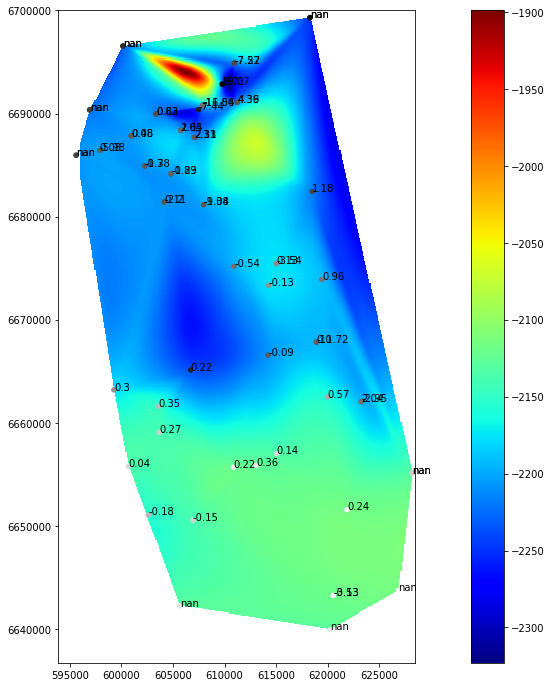

In [106]:
#Plot image of grid, this time with residual annotations
plt.figure(figsize=(20,12))
plt.imshow(gridded.T, origin='lower', extent=extent, cmap='jet')
plt.colorbar()

#Plot well tops and residuals
plt.scatter(x, y, s=20, c=z)

res_list = residuals.tolist()
res_list = [str(round(i, 2)) for i in res_list]

for i, txt in enumerate(res_list):
    plt.annotate(txt, (x[i], y[i]) , size=10)

### 2d Fourier Transform

In [ ]:
#Subset data to rectangle. In final version, will have already selected rectangle in ipyvolume phase

In [ ]:
gridded.shape

In [ ]:
ft = np.fft.fft2(gridded)